#Automated Valuation Model

## Overview
The Government of Manitoba, through the City of Winnipeg relies on property assessments to determine fair taxation for homeowners and businesses. Property taxes are one of the city’s largest revenue sources, funding essential public services like roads, transit, emergency response, and community programs.

Traditional property assessments are performed by human assessors, which is time-consuming, costly, and liable to inconsistency. With hundreds of thousands of parcels across Winnipeg, it is tough to manually re-assess each property frequently. This creates challenges in keeping valuations accurate and up to date with real estate market trends.

## Why this project?


The main objective of this project is to build and deploy a machine learning model to predict property assessment values in Winnipeg using publicly available data from the City of Winnipeg's Open Data Portal.

An Automated Valuation Model (AVM) will addresses aforementioned challenges by using statistical and machine learning methods to estimate property values in a consistent, transparent, and scalable way. An AVM enables:

- Fairness & Equity: similar properties are assessed consistently, ensuring fair tax distribution.

- Efficiency: the entire city’s properties can be revalued quickly, reducing manual workload.

- Transparency: model outputs can be explained using features such as lot size, living area, and distance to downtown.

- Adaptability: models can incorporate new data (e.g., neighbourhood trends, spatial features) to reflect market shifts.

By adopting an AVM, Winnipeg can strengthen public trust in its assessment system, improve operational efficiency, and ensure that property taxation remains fair, consistent, and aligned with current market conditions.

##Project Execution


## 1.0 Model Scaldfolding

### 1.1 Cloning Repository

In [4]:
 !git pull origin main

From https://github.com/BoseOmoniyi/property-valuation
 * branch            main       -> FETCH_HEAD
Already up to date.


In [3]:
# Starting the project by cloning my Github repository into this colab notebook
import os

if not os.path.exists('property-valuation'):
    !git clone https://github.com/BoseOmoniyi/property-valuation.git
    print("✓ Repository cloned")
else:
    print("✓ Repository already exists")

%cd property-valuation
print(f"Current directory: {os.getcwd()}")

Cloning into 'property-valuation'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 32 (delta 8), reused 23 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (32/32), 22.14 KiB | 686.00 KiB/s, done.
Resolving deltas: 100% (8/8), done.
✓ Repository cloned
/content/property-valuation
Current directory: /content/property-valuation


- Observation:
My Github repo has been cloned into the google colab, this gives me direct global access to my repo and the ability to save my work directly to Github  

### 1.2 Install Dependencies

In [5]:
# Install packages
print("Installing dependencies...")
!pip install -q pandas numpy scikit-learn matplotlib seaborn requests xgboost
print("✓ All dependencies installed")

Installing dependencies...
✓ All dependencies installed


### 1.3 Set Random Seeds

In [6]:
# Reproducibility
import random
import numpy as np
import os

RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
os.environ['PYTHONHASHSEED'] = str(RANDOM_STATE)

print("=" * 60)
print("REPRODUCIBILITY")
print("=" * 60)
print(f"Random State: {RANDOM_STATE}")
print("All random operations will use this seed.")
print("=" * 60)

REPRODUCIBILITY
Random State: 42
All random operations will use this seed.


### 1.4 Document Environment Information

In [7]:
# Document environment
import sys
import platform
from datetime import datetime

print("=" * 60)
print("ENVIRONMENT")
print("=" * 60)
print(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Python: {sys.version.split()[0]}")
print(f"Platform: {platform.platform()}")
print("=" * 60)

ENVIRONMENT
Date: 2025-10-05 20:41:58
Python: 3.12.11
Platform: Linux-6.6.97+-x86_64-with-glibc2.35


### 1.5 Show Configuration Information

In [8]:
# Import config
import sys
sys.path.insert(0, '/content/property-valuation')

from config import *

print("=" * 60)
print("CONFIGURATION")
print("=" * 60)
print(f"\n Reproducibility:")
print(f"  Random State: {RANDOM_STATE}")
print(f"\n API:")
print(f"  URL: {WINNIPEG_API_URL}")
print(f"  Dataset ID: {WINNIPEG_DATASET_ID}")
print(f"\n Data Split:")
print(f"  Test Size: {TEST_SIZE} ({int(TEST_SIZE*100)}%)")
print(f"\n Features:")
print(f"  Target: {TARGET_VARIABLE}")
print(f"  Features: {BASELINE_FEATURES}")
print("=" * 60)

CONFIGURATION

 Reproducibility:
  Random State: 42

 API:
  URL: https://data.winnipeg.ca/resource/d4mq-wa44.json
  Dataset ID: d4mq-wa44

 Data Split:
  Test Size: 0.2 (20%)

 Features:
  Target: Total.Assessed.Value.Num
  Features: ['Total.Living.Area.Num', 'Assessed.Land.Area.Num']


### 1.6 Import Libraries

In [9]:
# Force reimport after overwriting file
import importlib
import sys

# Remove old module from cache
if 'src.data_fetching' in sys.modules:
    del sys.modules['src.data_fetching']

# Now import fresh
from src.data_fetching import fetch_winnipeg_assessment_data, get_dataset_info

print("✓ Functions imported successfully!")

✓ Functions imported successfully!


In [37]:
# Import all libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from src.data_fetching import fetch_winnipeg_assessment_data, get_dataset_info

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
%matplotlib inline

print("SUCCESS: All libraries imported")

SUCCESS: All libraries imported


In [10]:
%%writefile src/data_fetching.py
"""
Fetch data from Winnipeg Open Data Portal API
"""
import pandas as pd
import requests
import json
from pathlib import Path
from datetime import datetime

# Import from config
import sys
sys.path.insert(0, '/content/property-valuation')
from config import WINNIPEG_API_URL

def get_dataset_info(api_url=None):
    """
    Get information about the dataset (row count, columns, etc.)
    """
    if api_url is None:
        api_url = WINNIPEG_API_URL

    print("Fetching dataset information...")

    # Get sample to see columns
    response = requests.get(api_url, params={'$limit': 1})
    response.raise_for_status()
    sample = response.json()

    # Try to get count
    try:
        count_params = {'$select': 'COUNT(*)'}
        count_response = requests.get(api_url, params=count_params)
        count_data = count_response.json()
        total_count = int(count_data[0]['COUNT']) if count_data else 'Unknown'
    except:
        total_count = 'Unknown'

    info = {
        'total_records': total_count,
        'columns': list(sample[0].keys()) if sample else [],
        'sample_record': sample[0] if sample else None
    }

    return info


def fetch_all_records(api_url, batch_size=50000):
    """
    Fetch all records from Socrata API with pagination.
    """
    all_data = []
    offset = 0

    print("Fetching all records with pagination...")

    while True:
        params = {
            '$limit': batch_size,
            '$offset': offset
        }

        print(f"  Fetching batch at offset {offset}...")
        response = requests.get(api_url, params=params)
        response.raise_for_status()

        data = response.json()

        if not data:
            break

        all_data.extend(data)
        offset += len(data)

        print(f"  Total records fetched: {len(all_data):,}")

        if len(data) < batch_size:
            break

    print(f"✓ Completed! Total records: {len(all_data):,}")

    df = pd.DataFrame(all_data)
    return df


def fetch_winnipeg_assessment_data(api_url=None, save_local=True, limit=None):
    """
    Fetch Winnipeg property assessment data from Open Data Portal API.
    """
    if api_url is None:
        api_url = WINNIPEG_API_URL

    print("=" * 60)
    print("FETCHING WINNIPEG ASSESSMENT DATA")
    print("=" * 60)
    print(f"API URL: {api_url}")
    print()

    try:
        if limit is None:
            # Fetch all data with pagination
            df = fetch_all_records(api_url)
        else:
            # Fetch limited records
            print(f"Fetching sample of {limit:,} records...")
            response = requests.get(api_url, params={'$limit': limit})
            response.raise_for_status()
            data = response.json()
            df = pd.DataFrame(data)
            print(f"✓ Successfully fetched {len(df):,} records")

        # Save local copy if requested
        if save_local:
            output_dir = Path('data/raw')
            output_dir.mkdir(parents=True, exist_ok=True)

            timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
            output_file = output_dir / f'Assessment_Parcels_{timestamp}.csv'

            df.to_csv(output_file, index=False)
            print(f"✓ Saved local copy to: {output_file}")

        print("=" * 60)
        return df

    except requests.exceptions.RequestException as e:
        print(f" Error fetching data: {e}")
        raise
    except json.JSONDecodeError as e:
        print(f" Error parsing JSON response: {e}")
        raise

Overwriting src/data_fetching.py


## 2.0 Dataset - City of Winnipeg Open Data

### 2.1 Retriving Dataset

In [11]:
### 2.1 # Get dataset information
print("Checking dataset structure...\n")

info = get_dataset_info()

print(f"Dataset Information:")
print(f"  Total Records: {info['total_records']}")
print(f"  Number of Columns: {len(info['columns'])}")

print(f"\nAvailable Columns:")
for i, col in enumerate(info['columns'], 1):
    print(f"  {i:2d}. {col}")

Checking dataset structure...

Fetching dataset information...
Dataset Information:
  Total Records: 244596
  Number of Columns: 35

Available Columns:
   1. roll_number
   2. street_number
   3. street_name
   4. street_type
   5. full_address
   6. neighbourhood_area
   7. market_region
   8. total_living_area
   9. building_type
  10. basement
  11. basement_finish
  12. year_built
  13. rooms
  14. air_conditioning
  15. fire_place
  16. attached_garage
  17. detached_garage
  18. pool
  19. property_use_code
  20. assessed_land_area
  21. property_influences
  22. zoning
  23. total_assessed_value
  24. assessment_date
  25. detail_url
  26. current_assessment_year
  27. property_class_1
  28. status_1
  29. assessed_value_1
  30. multiple_residences
  31. geometry
  32. dwelling_units
  33. centroid_lat
  34. centroid_lon
  35. gisid


###2.2 Data Description
The data contains the differnt attributes of the City of Winnipeg Property Assessment Data. The detailed data dictionary (all under Assumption) is given below.

**Data Dictionary**
Total columns: 45

 1. roll_number: Unique identifier assigned by the City of Winnipeg to each parcel or property record. Used for tax and assessment tracking.
 2. street_number:The numeric portion of the property’s civic address (e.g., 123)
 3. street_name: The name of the street where the property is located (e.g., "Main")
 4. street_type: The street type abbreviation (e.g., "Ave", "St", "Blvd")
 5. full_address: Complete address of the property (combining number, street name/type, and sometimes unit)
 6. neighbourhood_area: The defined neighbourhood or community area boundary within which the property lies (used for spatial grouping).
 7. market_region: Market valuation region that groups similar areas with comparable property market dynamics
 8. total_living_area: Total interior finished living space of the building (in square feet or metres)
 9. building_type: Category describing the structure (e.g., single detached, duplex, condominium, multi-family)
10. basement: Indicates whether the property has a basement (Yes/No or coded)
11. basement_finish: Describes whether the basement is finished, partially finished, or unfinished
12. year_built: Year the primary structure was originally built. Used to calculate property age.
13. rooms: Total number of rooms in the dwelling (may exclude bathrooms)
14. air_conditioning:Indicates if the property has central air conditioning installed (Yes/No)
15. fire_place: Indicates presence of one or more fireplaces (Yes/No)
16. attached_garage: Indicates whether the property includes an attached garage
17. detached_garage: Indicates whether the property includes a detached garage or secondary garage
18. pool: Indicates presence of a swimming pool (Yes/No)
19. property_use_code: Code used to identify the property’s use type (e.g., residential, commercial, institutional).
20. assessed_land_area: Size of the land parcel associated with the property, typically in square feet or metres
21. property_influences: Notes or flags that may influence the value (e.g., corner lot, near river, irregular shape)
22. zoning: Land use zoning category (e.g., R1, R2, C, M) defining allowable property uses under city by-laws
23. total_assessed_value: Total assessed value ($) of land and improvements combined, as determined by the city. (Target variable for AVM)
24. assessment_date: Date the assessment valuation was determined or recorded.
26. current_assessment_year: The tax/assessment roll year the data applies to
25. detail_url: :Link to the city’s property detail page for this parcel
27. property_class_1: Primary property classification (e.g., Residential, Commercial, Institutional)
28. status_1: Status flag associated with Property Class 1 (e.g., active, exempt)
29. assessed_value_1: Assessed value attributed to Property Class 1
30. multiple_residences: Indicates if multiple dwellings are on a single parcel (Yes/No or numeric)
31. geometry: Geospatial polygon geometry (used for mapping the parcel)
32. dwelling_units: Number of separate dwelling units within the property (e.g., 1, 2, 4)
33. centroid_lat: Latitude coordinate of the property’s centroid (used for spatial features)
34. centroid_lon: Longitude coordinate of the property’s centroid
35. gisid: Internal geographic information system (GIS) identifier.
36. property_class_2: Secondary property classification (if applicable)
37. status_2: Status associated with Property Class 2
38. assessed_value_2: Assessed value for Property Class 2
39. property_class_3: Tertiary property classification (if applicable)
40. status_3: Status associated with Property Class 3
41. assessed_value_3: Assessed value for Property Class 3
42. water_frontage_measurement: Linear measurement of property boundary along a body of water (metres/feet)
43. sewer_frontage_measurement: Length of property boundary connected to municipal sewer line
44. unit_number: Unit or suite number for multi-unit buildings (if applicable).
45. number_floors_condo: Number of floors in the condominium structure or multi-unit building

###2.3 Fetch Sample Data For Exploration

In [59]:
 #Fetch sample data for exploration
print("Refetching and cleaning data properly...")

# Fetch fresh sample
df_sample = fetch_winnipeg_assessment_data(limit=1000, save_local=False)

Refetching and cleaning data properly...
FETCHING WINNIPEG ASSESSMENT DATA
API URL: https://data.winnipeg.ca/resource/d4mq-wa44.json

Fetching sample of 1,000 records...
SUCCESS: Successfully fetched 1,000 records


In [60]:
# Display all column names
print("=" * 60)
print("Dataset Columns")
print("=" * 60)
print(f"\nTotal columns: {len(df_sample.columns)}\n")

for i, col in enumerate(df_sample.columns, 1):
    print(f"{i:2d}. {col}")

Dataset Columns

Total columns: 45

 1. roll_number
 2. street_number
 3. street_name
 4. street_type
 5. full_address
 6. neighbourhood_area
 7. market_region
 8. total_living_area
 9. building_type
10. basement
11. basement_finish
12. year_built
13. rooms
14. air_conditioning
15. fire_place
16. attached_garage
17. detached_garage
18. pool
19. property_use_code
20. assessed_land_area
21. property_influences
22. zoning
23. total_assessed_value
24. assessment_date
25. detail_url
26. current_assessment_year
27. property_class_1
28. status_1
29. assessed_value_1
30. multiple_residences
31. geometry
32. dwelling_units
33. centroid_lat
34. centroid_lon
35. gisid
36. property_class_2
37. status_2
38. assessed_value_2
39. property_class_3
40. status_3
41. assessed_value_3
42. water_frontage_measurement
43. sewer_frontage_measurement
44. unit_number
45. number_floors_condo


In [61]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 45 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   roll_number                 1000 non-null   object
 1   street_number               903 non-null    object
 2   street_name                 994 non-null    object
 3   street_type                 994 non-null    object
 4   full_address                994 non-null    object
 5   neighbourhood_area          1000 non-null   object
 6   market_region               1000 non-null   object
 7   total_living_area           854 non-null    object
 8   building_type               836 non-null    object
 9   basement                    854 non-null    object
 10  basement_finish             854 non-null    object
 11  year_built                  854 non-null    object
 12  rooms                       854 non-null    object
 13  air_conditioning            836 non-null    objec

###Observation
- All 45 columns in the dataset are object datatyope including the target variable, total_assessed_value
- We will need to convert them to numeric columns



In [62]:
# checking the columns  value points
# Show columns with sample values in a table
print("=" * 80)
print("COLUMNS AND SAMPLE VALUES")
print("=" * 80)

# Create a transposed view
sample_display = df_sample.head(5).T  # T = transpose

display(sample_display)

COLUMNS AND SAMPLE VALUES


,0,1,2,3,4
roll_number,01000001000,01000005500,01000008000,01000008200,01000008400
street_number,1636,1584,1574,1550,1538
street_name,MCCREARY,MCCREARY,MCCREARY,MCCREARY,MCCREARY
street_type,ROAD,ROAD,ROAD,ROAD,ROAD
full_address,1636 MCCREARY ROAD,1584 MCCREARY ROAD,1574 MCCREARY ROAD,1550 MCCREARY ROAD,1538 MCCREARY ROAD
neighbourhood_area,WILKES SOUTH,WILKES SOUTH,WILKES SOUTH,WILKES SOUTH,WILKES SOUTH
market_region,"6, CHARLESWOOD","6, CHARLESWOOD","6, CHARLESWOOD","6, CHARLESWOOD","6, CHARLESWOOD"
total_living_area,1313,4007,1052,3120,1510
building_type,ONE STOREY,TWO STOREY,ONE STOREY,ONE STOREY,ONE STOREY
basement,Yes,Yes,No,Yes,Yes


### Observations
- There are columns with complex data types and we need to drop them
     1. detail_url (contains unhashable type)
     2. geometry (contains unhashable type)
- There are identifier columns that we need to drop ('gisid', 'centroid_lon', 'centroid_lat', 'roll_number')

- All columns have object datatype including the target variable, we need to change the numeric-looking (string) columns to numeric datatype


**Create good columns**

In [68]:
  #Find and keep good columns (without unhashable type)
good_cols = []
for col in df_sample.columns:
    try:
        first_val = df_sample[col].dropna().iloc[0] if len(df_sample[col].dropna()) > 0 else None
        if first_val is not None:
            hash(first_val)
        good_cols.append(col)
    except TypeError:
        pass

# Keep only good columns
df_sample = df_sample[good_cols].copy()

**Drop Identifier Columns**

In [75]:
# Drop identifiers
identifier_cols = ['gisid', 'centroid_lon', 'centroid_lat', 'roll_number']
cols_to_drop = [col for col in identifier_cols if col in df_sample.columns]
df_sample = df_sample.drop(columns=cols_to_drop)

**Convert numeric-looking object columns to numeric datatype**

In [ ]:
# Convert object columns to numeric
#print("=" * 80)
#print("CONVERTING OBJECT COLUMNS TO NUMERIC")
#print("=" * 80)

converted_cols = []
failed_cols = []

for col in df_sample.columns:
    if df_sample[col].dtype == 'object':
        try:
            # Remove common formatting ($ , spaces)
            cleaned = df_sample[col].astype(str).str.replace('$', '').str.replace(',', '').str.strip()

            # Try conversion
            numeric_col = pd.to_numeric(cleaned, errors='coerce')

            # Check if at least 50% converted successfully
            non_null_original = df_sample[col].notna().sum()
            non_null_converted = numeric_col.notna().sum()

            if non_null_converted >= non_null_original * 0.5:
                df_sample[col] = numeric_col
                converted_cols.append(col)
                print(f"✓ Converted: {col}")
            else:
                failed_cols.append(col)
                print(f"✗ Skipped: {col} (mostly text)")

        except Exception as e:
            failed_cols.append(col)
            print(f"✗ Error: {col} - {str(e)}")

print("\n" + "=" * 80)
print(f"SUMMARY")
print("=" * 80)
print(f"Converted to numeric: {len(converted_cols)}")
print(f"Remained as text: {len(failed_cols)}")

# Show final data types
print("\nFinal data types:")
print(df_sample.dtypes.value_counts())

###2.4 Data Shape

In [69]:
#checking to see if there are any missing values
df_sample.isnull().values.any()


np.True_

- There are missing data, so we need to drill down

In [70]:
# Total missing per column
df_sample.isnull().sum().sort_values(ascending=False)

,0
status_3,996
property_class_3,996
assessed_value_3,996
number_floors_condo,982
unit_number,982
status_2,923
property_class_2,923
assessed_value_2,923
property_influences,396
air_conditioning,164


###Observation
-  Total_Assessed_Value (target variable) has just only 1 missing value. So the null row can be removed
- Any other key features with missing values will be treated later

In [73]:
# Remove row with missing target
print(f"Before: {len(df_sample)} rows")

df_sample = df_sample[df_sample['total_assessed_value'].notna()].copy()

print(f"After: {len(df_sample)} rows")
print(f"Removed: 1 row")

print(f"Target variable now 100% complete")

Before: 1000 rows
After: 999 rows
Removed: 1 row
Target variable now 100% complete


### Duplicate Analysis

In [74]:
# Check for duplicates

duplicates = df_sample.duplicated().sum()

print(f"\nDuplicate rows: {duplicates:,} ({100*duplicates/len(df_sample):.2f}%)")

if duplicates > 0:
    print(f"\nShowing first 5 duplicate rows:")
    display(df_sample[df_sample.duplicated()].head())

    print(f"\nDuplicate indices:")
    print(df_sample[df_sample.duplicated()].index.tolist()[:20])
else:
    print("\n✓ No duplicate rows")


Duplicate rows: 0 (0.00%)

✓ No duplicate rows


In [ ]:
# Remove row with missing value
#df_sample = df_sample[df_sample['total_assessed_value'].notna()].copy()


In [43]:
# Checking for duplicates:
# Find and exclude columns with complex data types
print("Identifying columns with complex data types")

problem_cols = []
good_cols = []

for col in df_sample.columns:
    try:
        # Try to hash the first non-null value
        first_val = df_sample[col].dropna().iloc[0] if len(df_sample[col].dropna()) > 0 else None
        if first_val is not None:
            hash(first_val)  # This will fail for dict/list
        good_cols.append(col)
    except TypeError:
        problem_cols.append(col)
        print(f"  Problem column: {col} (contains unhashable type)")

print(f"\nGood columns: {len(good_cols)}")
print(f"Problem columns: {len(problem_cols)}")

# Now check duplicates using only good columns
if good_cols:
    duplicates = df_sample[good_cols].duplicated().sum()
    print(f"\nDuplicate rows (based on {len(good_cols)} columns): {duplicates}")
    print(f"Percentage: {100*duplicates/len(df_sample):.2f}%")
else:
    print("\nNo columns available for duplicate checking")

Identifying columns with complex data types
  Problem column: detail_url (contains unhashable type)
  Problem column: geometry (contains unhashable type)

Good columns: 43
Problem columns: 2

Duplicate rows (based on 43 columns): 0
Percentage: 0.00%


- Based on 43 good columns, there are 0.00% duplicates data

In [44]:
# Checking data infos for unique values
# Count unique values per column (excluding problematic columns)


unique_counts = []

for col in good_cols:  # Use the good_cols from previous cell
    n_unique = df_sample[col].nunique()
    n_total = len(df_sample[col])
    n_missing = df_sample[col].isnull().sum()

    unique_counts.append({
        'Column': col,
        'Unique_Values': n_unique,
        'Total_Values': n_total,
        'Missing': n_missing,
        'Unique_Ratio': n_unique / (n_total - n_missing) if (n_total - n_missing) > 0 else 0
    })

unique_df = pd.DataFrame(unique_counts).sort_values('Unique_Values', ascending=False)

print("\nColumns sorted by number of unique values:\n")
display(unique_df.head(20))

# Summary
print("\n" + "=" * 80)
print("Summary")
print("=" * 80)
print(f"Columns with all unique values: {len(unique_df[unique_df['Unique_Ratio'] >= 0.99])}")
print(f"Columns with 1 unique value (constant): {len(unique_df[unique_df['Unique_Values'] == 1])}")


Columns sorted by number of unique values:



,Column,Unique_Values,Total_Values,Missing,Unique_Ratio
0,roll_number,1000,1000,0,1.000000
32,gisid,982,1000,0,0.982000
31,centroid_lon,982,1000,0,0.982000
30,centroid_lat,982,1000,0,0.982000
4,full_address,916,1000,6,0.921529
19,assessed_land_area,693,1000,19,0.706422
1,street_number,517,1000,97,0.572536
7,total_living_area,458,1000,146,0.536300
27,assessed_value_1,420,1000,1,0.420420
22,total_assessed_value,418,1000,1,0.418418



Summary
Columns with all unique values: 3
Columns with 1 unique value (constant): 5


- Observation:

- Columns with All Unique Values (3 columns)
These are identifier columns (gisid, centroid_log and centroid_lat.) They will not be useful for modelling.

- Columns with 1 Unique Value (5 columns)
These are constant columns, cannot support modelling. Will be dropped off

In [54]:
# Save original data with all columns
df_original = df_sample.copy()

# Now drop identifiers from working copy
identifier_cols = ['gisid', 'centroid_lon', 'centroid_lat', 'roll_number']
cols_to_drop = [col for col in identifier_cols if col in df_sample.columns]

print(f"Dropping {len(cols_to_drop)} identifier columns from working dataset")
df_sample = df_sample.drop(columns=cols_to_drop)

print(f"\n✓ df_original: {df_original.shape} (has all columns)")
print(f"✓ df_sample: {df_sample.shape} (identifiers dropped)")

Dropping 4 identifier columns from working dataset

✓ df_original: (1000, 45) (has all columns)
✓ df_sample: (1000, 41) (identifiers dropped)


##3.0 Exploratory Data Analysis - Visualization and Distribution

###EDA
- To do basic visualization and examine correlations within the variables, we need to convert the datatypes to numeric

In [55]:
# Convert target variable to numeric
print("Converting total_assessed_value to numeric...")

# Check current type
print(f"Before: {df_sample['total_assessed_value'].dtype}")
print(f"Sample values: {df_sample['total_assessed_value'].head().tolist()}")

# Convert to numeric (handles $, commas, etc.)
df_sample['total_assessed_value'] = pd.to_numeric(
    df_sample['total_assessed_value'].astype(str).str.replace('$', '').str.replace(',', ''),
    errors='coerce'
)

print(f"\nAfter: {df_sample['total_assessed_value'].dtype}")
print(f"Sample values: {df_sample['total_assessed_value'].head().tolist()}")
print(f"Missing after conversion: {df_sample['total_assessed_value'].isnull().sum()}")

Converting total_assessed_value to numeric...
Before: float64
Sample values: [723000.0, 1619000.0, 570000.0, 743000.0, 577000.0]

After: float64
Sample values: [723000.0, 1619000.0, 570000.0, 743000.0, 577000.0]
Missing after conversion: 1


In [57]:
# Work with good_cols only (no dict columns)
print("=" * 80)
print("CONVERTING NUMERIC COLUMNS (Clean columns only)")
print("=" * 80)

# Filter to only good columns first
df_clean = df_sample[good_cols].copy()

converted_cols = []

for col in df_clean.columns:
    if df_clean[col].dtype == 'object':
        try:
            # Remove common formatting
            cleaned = df_clean[col].astype(str).str.replace('$', '').str.replace(',', '').str.strip()

            # Try conversion
            numeric_col = pd.to_numeric(cleaned, errors='coerce')

            # If at least 50% converted successfully, it's probably numeric
            non_null_original = df_clean[col].notna().sum()
            non_null_converted = numeric_col.notna().sum()

            if non_null_converted >= non_null_original * 0.5:
                df_clean[col] = numeric_col
                converted_cols.append(col)
                print(f"✓ Converted: {col}")
        except Exception as e:
            print(f"✗ Failed: {col} - {e}")

print(f"\n{len(converted_cols)} columns converted to numeric")

# Now use df_clean for analysis
df_sample = df_clean

print(f"\nNew shape: {df_sample.shape}")
print(f"Data types: {df_sample.dtypes.value_counts()}")

CONVERTING NUMERIC COLUMNS (Clean columns only)


KeyError: "['roll_number', 'centroid_lat', 'centroid_lon', 'gisid'] not in index"

In [58]:
# Finding and converting all columns that look like numbers

converted_cols = []

for col in df_sample.columns:
    if df_sample[col].dtype == 'object':
        # Try to convert to numeric
        try:
            # Remove common formatting
            cleaned = df_sample[col].astype(str).str.replace('$', '').str.replace(',', '').str.strip()

            # Try conversion
            numeric_col = pd.to_numeric(cleaned, errors='coerce')

            # If at least 50% converted successfully, it's probably numeric
            non_null_original = df_sample[col].notna().sum()
            non_null_converted = numeric_col.notna().sum()

            if non_null_converted >= non_null_original * 0.5:
                df_sample[col] = numeric_col
                converted_cols.append(col)
                print(f"✓ Converted: {col}")
        except:
            pass

print(f"\n{len(converted_cols)} columns converted to numeric")


0 columns converted to numeric


- Now we have converted all the numeric looking columns ( with data stored as strings) to numeric dtp
- We will now check to verify the conversion

In [49]:
# Check data types after conversion
print("=" * 80)
print("Data types After Conversion")
print("=" * 80)

print("\nData type counts:")
print(df_sample.dtypes.value_counts())

# Show numeric columns
numeric_cols = df_sample.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).columns
print(f"\nNumeric columns: {len(numeric_cols)}")

if len(numeric_cols) > 0:
    print("\nNumeric columns list:")
    for col in numeric_cols[:20]:  # Show first 20
        print(f"  - {col}")

Data types After Conversion

Data type counts:
object     26
float64    16
int64       3
Name: count, dtype: int64

Numeric columns: 19

Numeric columns list:
  - roll_number
  - street_number
  - total_living_area
  - year_built
  - rooms
  - assessed_land_area
  - total_assessed_value
  - current_assessment_year
  - assessed_value_1
  - dwelling_units
  - centroid_lat
  - centroid_lon
  - gisid
  - assessed_value_2
  - assessed_value_3
  - water_frontage_measurement
  - sewer_frontage_measurement
  - unit_number
  - number_floors_condo


- We now have 19 Numeric columns that includes the target variable

In [53]:
# Find all unique identifier columns
print("=" * 80)
print("IDENTIFYING UNIQUE IDENTIFIER COLUMNS")
print("=" * 80)

identifier_cols = []

for col in df_sample.columns:
    n_unique = df_sample[col].nunique()
    n_total = len(df_sample)

    # If 95%+ unique, it's likely an identifier
    if n_unique / n_total > 0.95:
        identifier_cols.append(col)
        print(f"  {col}: {n_unique} unique values ({100*n_unique/n_total:.1f}% unique)")

print(f"\nFound {len(identifier_cols)} identifier columns")

IDENTIFYING UNIQUE IDENTIFIER COLUMNS
  roll_number: 1000 unique values (100.0% unique)


TypeError: unhashable type: 'dict'

### Visualization of Distribution of Numeric features

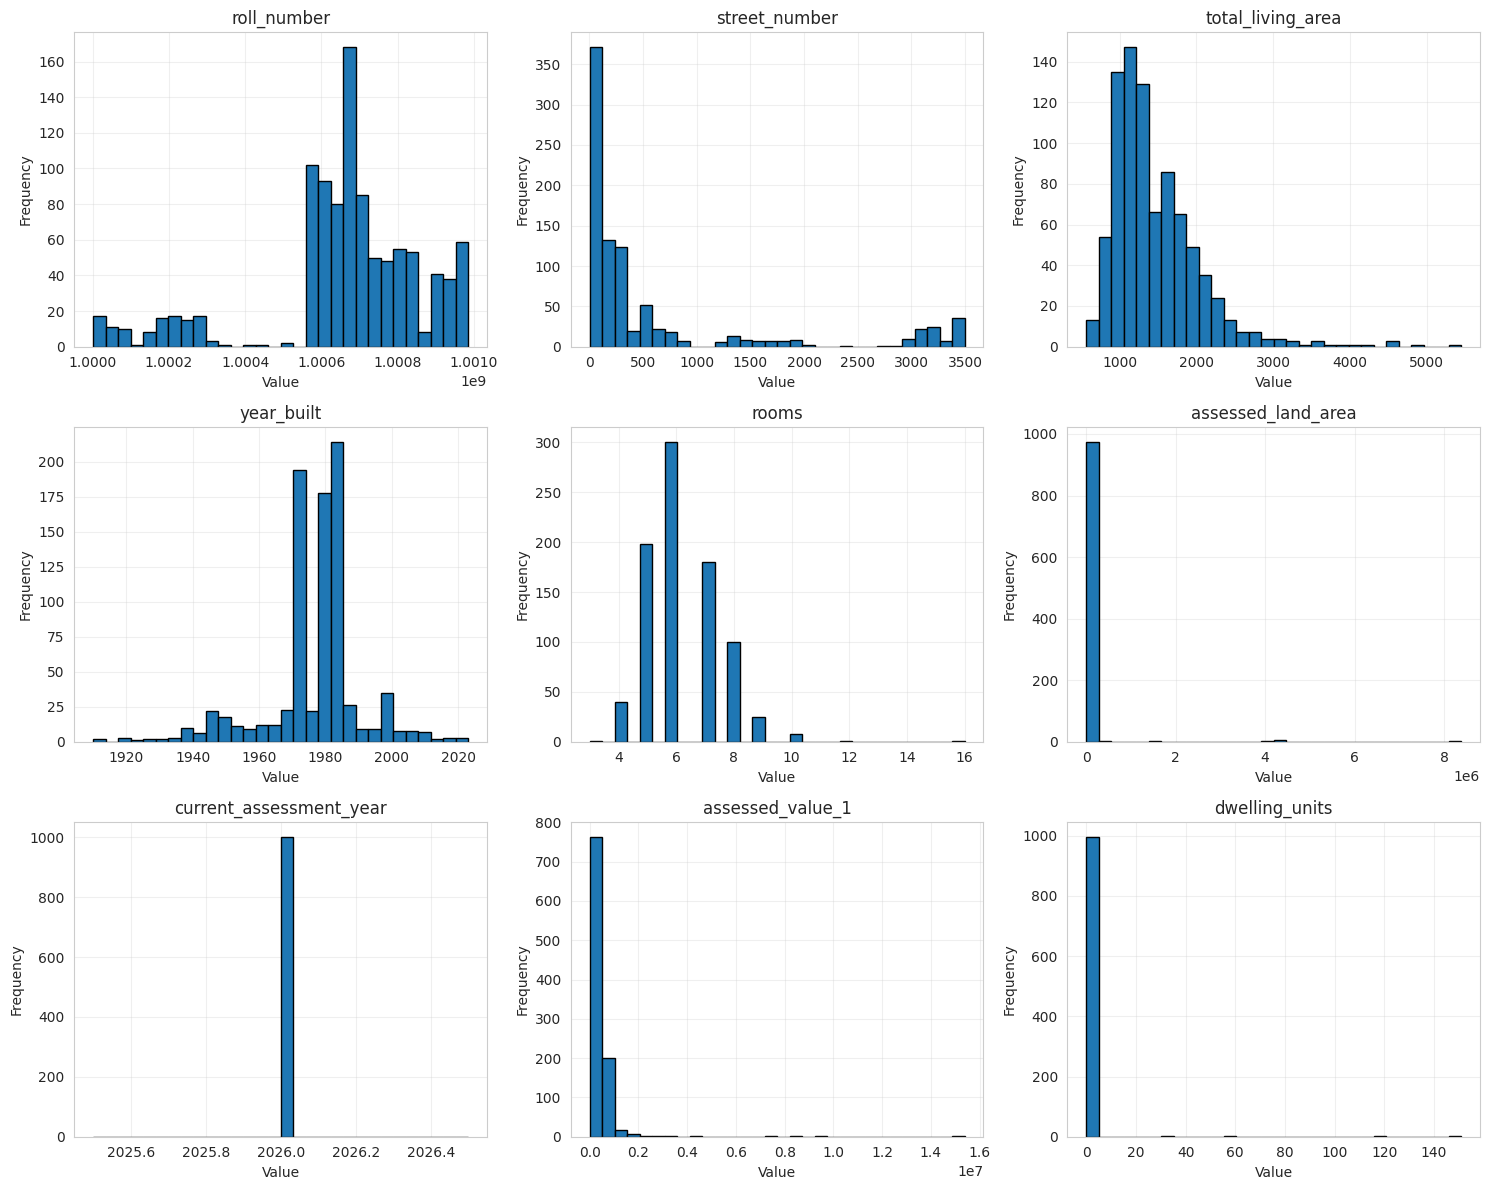

In [50]:
# Visualize distributions of key numeric features

numeric_cols = df_sample.select_dtypes(include=['int64', 'float64']).columns
# Exclude target for now
numeric_features = [col for col in numeric_cols if col != 'total_assessed_value']

# Show first 9 numeric features
n_features = min(9, len(numeric_features))

if n_features > 0:
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    axes = axes.flatten()

    for i, col in enumerate(numeric_features[:n_features]):
        df_sample[col].hist(bins=30, ax=axes[i], edgecolor='black')
        axes[i].set_title(col)
        axes[i].set_xlabel('Value')
        axes[i].set_ylabel('Frequency')
        axes[i].grid(alpha=0.3)

    # Hide extra subplots
    for i in range(n_features, 9):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No numeric features to visualize")

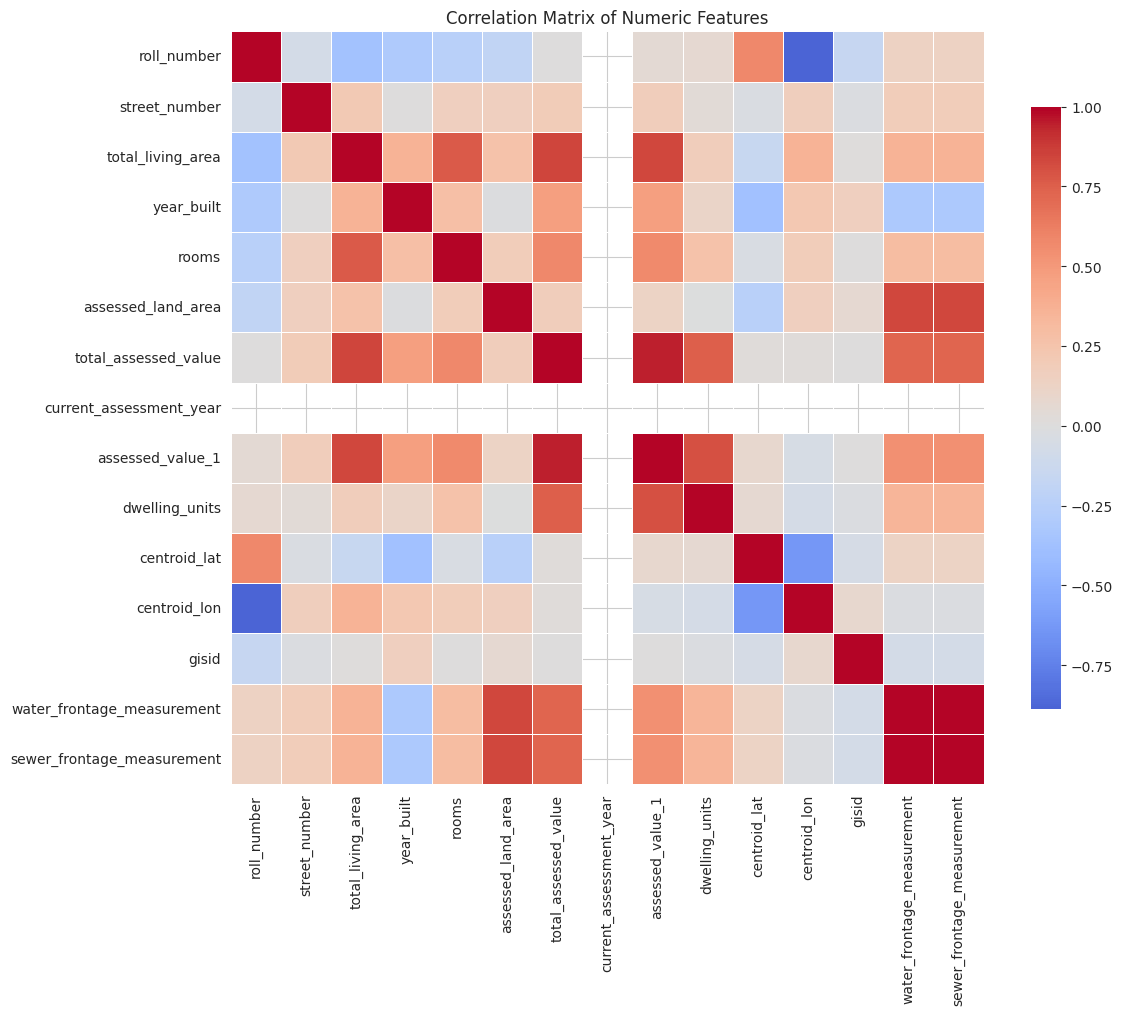


Showing correlation for 15 numeric features


In [52]:
# Correlation matrix for numeric features


# Select numeric columns with low missing data
numeric_cols = df_sample.select_dtypes(include=['int64', 'float64']).columns
low_missing_numeric = []

for col in numeric_cols:
    if df_sample[col].isnull().sum() / len(df_sample) < 0.3:  # Less than 30% missing
        low_missing_numeric.append(col)

if len(low_missing_numeric) > 1:
    # Calculate correlation
    corr_matrix = df_sample[low_missing_numeric].corr()

    # Plot heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0,
                square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
    plt.title('Correlation Matrix of Numeric Features')
    plt.tight_layout()
    plt.show()

    print(f"\nShowing correlation for {len(low_missing_numeric)} numeric features")
else:
    print("Not enough numeric features for correlation matrix")